In [ ]:
## Purpose - fill in the irritating gaps in the value coverage Waves 18/19 of the British Election Study

# all previous waves have al1/2/3/4/5,lr1/2/3/4/5 values - but not W18/19 so we have some annoying gaps

# there's also a question of what to do with the generalised two factor inference program when we have missing values

# the inference here got an R^2 ~ 60% which seems *alright* - but not so good as to justify overwriting prevoous attempts at filling gaps



In [1]:
%%time
dataset_name = "W19_comb"
df_list = [ "BES_Panel" ]

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}

if "id" in BES_Panel.columns:
    BES_Panel = BES_Panel.set_index("id").sort_index()

(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')

Toggle code

var_type (7911, 14)
Wall time: 35.2 s


In [2]:
BES_Panel = pd.read_pickle("..\\BES_analysis_data\\"+"W19_comb"+os.sep+"BES_Panelv02",compression='zip')
BES_Panel = BES_Panel.set_index("id")
BES_Panel = BES_Panel.sort_index()

In [3]:
BES_reduced_with_na = pd.read_pickle("E:\\BES_analysis_data"+os.sep+"BES_reduced_with_na.zip",compression='zip')
BES_reduced_with_na = BES_reduced_with_na.loc[BES_Panel.index].sort_index()

In [ ]:
# should check whether this is necessary

In [35]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    

import shap
import xgboost as xgb
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves, mask)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values, train.columns, alg)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
#     return BES_Panel["generalElectionVoteW19"].notnull()
    return 1



def create_train(drop_other_waves,mask):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list][mask].astype('float32')


def create_target(target_var):
    
    return df[target_var].astype('float32')

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.03,
 n_estimators= 600,
 max_depth=6,
 min_child_weight=8,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)

# wave_pair = ["W8","W9"]
def add_pairs(wave_pair):
    pair1_cols = [x for x in search(df,wave_pair[0]).index if x.replace(wave_pair[0],wave_pair[1]) in df.columns]
    pair2_cols = [x.replace(wave_pair[0],wave_pair[1]) for x in pair1_cols]

    prefix = "D"+"_".join([x.replace("W","") for x in wave_pair])
    delta_df = pd.DataFrame(df[pair2_cols].values - df[pair1_cols].values,
                            columns = [prefix+x.replace(wave_pair[0],"") for x in pair1_cols])
    if pair1_cols!=[]:
        biggest_dtype = df[pair1_cols].dtypes.value_counts().index[-1].name
        biggest_dtype = "Int64" # nino_df screws this up by introducing floats!
        delta_df = delta_df.astype(biggest_dtype).astype('float32')
        df[delta_df.columns] = delta_df
    
def shap_array(shap_values, train_columns, threshold = .1, min_features = 50):

    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    return pd.Series(global_shap_vals[inds][::-1],index = train_columns[inds][::-1])    

def hash_df(sourcedf,destinationdf,*column):
    columnName = ''
    destinationdf['hash_'+columnName.join(column)] = pd.DataFrame(sourcedf[list(column)].values.sum(axis=1))[0].str.encode('utf-8').apply(lambda x: (hashlib.sha512(x).hexdigest().upper()))
# hash_df(df,df,'ID','Salt')

def drop_duplicate_columns(df):
    return df.loc[:,~df.columns.duplicated()]

In [9]:
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()

In [28]:
pan_dataset_allr_values.isnull().sum()

Economic: Left(0) <-> Right(200){uniform}                      2513
Social: Liberalism(0) <-> Conservatism(200){uniform}           2513
Economic: Left <-> Right{gaussian-ish}                         2513
Social: Liberalism <-> Conservatism{gaussian-ish}              2513
Economic: Left <-> Right{gaussian-ish}completish               2254
Economic: Left <-> Right{gaussian-ish}complete                  816
Social: Liberalism <-> Conservatism{gaussian-ish}completish    2174
Social: Liberalism <-> Conservatism{gaussian-ish}complete       736
dtype: int64

In [26]:
pan_dataset_allr_values[ pan_dataset_allr_values.columns[2] ].isnull().sum()

2513

In [27]:
pan_dataset_allr_values[ pan_dataset_allr_values.columns[3] ].isnull().sum()

2513

In [ ]:
# better to use gaussian or linear???
# start with gaussian

In [14]:
lr_corrs = BES_reduced_with_na.astype('float32').corrwith(pan_dataset_allr_values[ pan_dataset_allr_values.columns[2] ])
al_corrs = BES_reduced_with_na.astype('float32').corrwith(pan_dataset_allr_values[ pan_dataset_allr_values.columns[3] ])

In [30]:
# lr_corrs.abs().dropna().sort_values(ascending=False).head(5000)

In [24]:
base_value_vars = list( match(BES_reduced_with_na,"(lr|al)_scale|(lr|al)\d").index )



In [42]:
treatment_dict = {}

[20:24:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.10086
Will train until validation_0-rmse hasn't improved in 60.0 rounds.
[1]	validation_0-rmse:1.08539
[2]	validation_0-rmse:1.07011
[3]	validation_0-rmse:1.05573
[4]	validation_0-rmse:1.04216
[5]	validation_0-rmse:1.02883
[6]	validation_0-rmse:1.01585
[7]	validation_0-rmse:1.00336
[8]	validation_0-rmse:0.991538
[9]	validation_0-rmse:0.979918
[10]	validation_0-rmse:0.969197
[11]	validation_0-rmse:0.958458
[12]	validation_0-rmse:0.948304
[13]	validation_0-rmse:0.938518
[14]	validation_0-rmse:0.929223
[15]	validation_0-rmse:0.920023
[16]	validation_0-rmse:0.911328
[17]	validation_0-rmse:0.903154
[18]	validation_0-rmse:0.895127
[19]	validation_0-rmse:0.887502
[20]	validation_0-rmse:0.880206
[21]	validation_0-rmse:0.873173
[22]	validation_0-rmse:0.866405
[23]	validation_0-rmse:0.859697
[24]	validation_0-rmse:0.85329
[25]	validation_0-rmse:0.847199
[26]

[248]	validation_0-rmse:0.66234
[249]	validation_0-rmse:0.662224
[250]	validation_0-rmse:0.662155
[251]	validation_0-rmse:0.662069
[252]	validation_0-rmse:0.661987
[253]	validation_0-rmse:0.661881
[254]	validation_0-rmse:0.661756
[255]	validation_0-rmse:0.661663
[256]	validation_0-rmse:0.661593
[257]	validation_0-rmse:0.661535
[258]	validation_0-rmse:0.661433
[259]	validation_0-rmse:0.661388
[260]	validation_0-rmse:0.661309
[261]	validation_0-rmse:0.661219
[262]	validation_0-rmse:0.661094
[263]	validation_0-rmse:0.661005
[264]	validation_0-rmse:0.660901
[265]	validation_0-rmse:0.660852
[266]	validation_0-rmse:0.660814
[267]	validation_0-rmse:0.660758
[268]	validation_0-rmse:0.660687
[269]	validation_0-rmse:0.660627
[270]	validation_0-rmse:0.660555
[271]	validation_0-rmse:0.660467
[272]	validation_0-rmse:0.660361
[273]	validation_0-rmse:0.660259
[274]	validation_0-rmse:0.660206
[275]	validation_0-rmse:0.660171
[276]	validation_0-rmse:0.660104
[277]	validation_0-rmse:0.660061
[278]	valid

[497]	validation_0-rmse:0.652487
[498]	validation_0-rmse:0.652439
[499]	validation_0-rmse:0.652423
[500]	validation_0-rmse:0.652382
[501]	validation_0-rmse:0.652356
[502]	validation_0-rmse:0.652327
[503]	validation_0-rmse:0.652297
[504]	validation_0-rmse:0.652282
[505]	validation_0-rmse:0.652274
[506]	validation_0-rmse:0.652252
[507]	validation_0-rmse:0.652241
[508]	validation_0-rmse:0.652233
[509]	validation_0-rmse:0.652192
[510]	validation_0-rmse:0.652186
[511]	validation_0-rmse:0.652179
[512]	validation_0-rmse:0.652174
[513]	validation_0-rmse:0.65216
[514]	validation_0-rmse:0.652135
[515]	validation_0-rmse:0.652125
[516]	validation_0-rmse:0.652114
[517]	validation_0-rmse:0.652097
[518]	validation_0-rmse:0.652097
[519]	validation_0-rmse:0.652096
[520]	validation_0-rmse:0.652064
[521]	validation_0-rmse:0.652048
[522]	validation_0-rmse:0.652031
[523]	validation_0-rmse:0.652012
[524]	validation_0-rmse:0.65198
[525]	validation_0-rmse:0.651967
[526]	validation_0-rmse:0.651952
[527]	valida

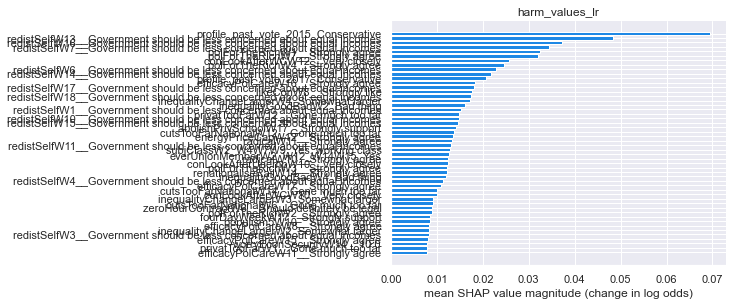

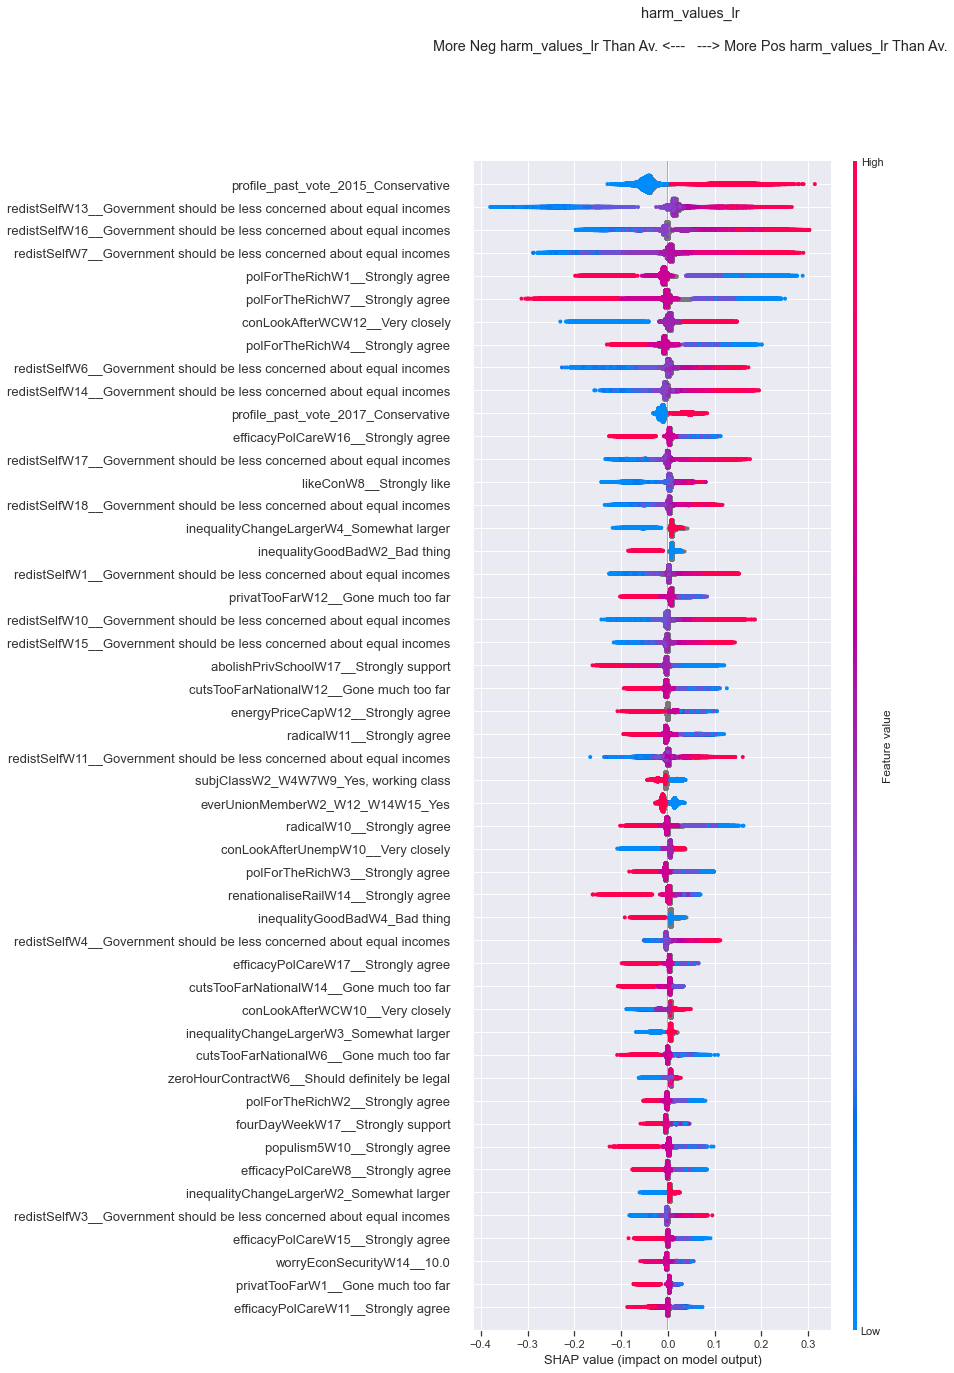

Wall time: 2h 14min 24s


In [52]:
%%time

Treatment = "predicted_lr_values"
var1 = "harm_values_lr"
lr_pan_data_col = pan_dataset_allr_values.columns[2]
BES_reduced_with_na[var1]= pan_dataset_allr_values[ lr_pan_data_col ]

base = "harm_values_lr"

temp_mask = BES_reduced_with_na[var1].notnull()

lr_predictors = [x for x in lr_corrs.abs().dropna().sort_values(ascending=False).head(5000).index if x not in base_value_vars]
lr_predictors.append(var1)
df = BES_reduced_with_na[lr_predictors][temp_mask].astype('float32')

var_stub = var1

var_list = [var_stub]
var_stub_list = [var_stub]


(explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment] = shap_array(shap_values, train_columns, threshold = .1, min_features = 50)

In [53]:
lr_train_columns = train_columns
lr_alg = alg
mask = pan_dataset_allr_values[ lr_pan_data_col ].isnull()
lr_pred = lr_alg.predict(BES_reduced_with_na[lr_train_columns][mask].astype('float32'))

[03:19:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.10314
Will train until validation_0-rmse hasn't improved in 59.800000000000004 rounds.
[1]	validation_0-rmse:1.08837
[2]	validation_0-rmse:1.07391
[3]	validation_0-rmse:1.06006
[4]	validation_0-rmse:1.04687
[5]	validation_0-rmse:1.03424
[6]	validation_0-rmse:1.02193
[7]	validation_0-rmse:1.01014
[8]	validation_0-rmse:0.998794
[9]	validation_0-rmse:0.987842
[10]	validation_0-rmse:0.977542
[11]	validation_0-rmse:0.967359
[12]	validation_0-rmse:0.957778
[13]	validation_0-rmse:0.94841
[14]	validation_0-rmse:0.939531
[15]	validation_0-rmse:0.931062
[16]	validation_0-rmse:0.923023
[17]	validation_0-rmse:0.915243
[18]	validation_0-rmse:0.907686
[19]	validation_0-rmse:0.900632
[20]	validation_0-rmse:0.893539
[21]	validation_0-rmse:0.886855
[22]	validation_0-rmse:0.880414
[23]	validation_0-rmse:0.874024
[24]	validation_0-rmse:0.868096
[25]	validation_0-rmse

[247]	validation_0-rmse:0.682154
[248]	validation_0-rmse:0.682063
[249]	validation_0-rmse:0.68199
[250]	validation_0-rmse:0.681898
[251]	validation_0-rmse:0.681768
[252]	validation_0-rmse:0.681686
[253]	validation_0-rmse:0.681598
[254]	validation_0-rmse:0.681552
[255]	validation_0-rmse:0.68148
[256]	validation_0-rmse:0.681369
[257]	validation_0-rmse:0.681297
[258]	validation_0-rmse:0.681188
[259]	validation_0-rmse:0.681095
[260]	validation_0-rmse:0.681006
[261]	validation_0-rmse:0.680921
[262]	validation_0-rmse:0.680878
[263]	validation_0-rmse:0.680807
[264]	validation_0-rmse:0.680718
[265]	validation_0-rmse:0.680625
[266]	validation_0-rmse:0.680531
[267]	validation_0-rmse:0.680456
[268]	validation_0-rmse:0.680414
[269]	validation_0-rmse:0.680347
[270]	validation_0-rmse:0.680262
[271]	validation_0-rmse:0.680209
[272]	validation_0-rmse:0.680148
[273]	validation_0-rmse:0.680058
[274]	validation_0-rmse:0.679967
[275]	validation_0-rmse:0.679884
[276]	validation_0-rmse:0.679796
[277]	valida

[497]	validation_0-rmse:0.670337
[498]	validation_0-rmse:0.670331
[499]	validation_0-rmse:0.670293
[500]	validation_0-rmse:0.670255
[501]	validation_0-rmse:0.670249
[502]	validation_0-rmse:0.670226
[503]	validation_0-rmse:0.67019
[504]	validation_0-rmse:0.670153
[505]	validation_0-rmse:0.670117
[506]	validation_0-rmse:0.670096
[507]	validation_0-rmse:0.670089
[508]	validation_0-rmse:0.67008
[509]	validation_0-rmse:0.670042
[510]	validation_0-rmse:0.670041
[511]	validation_0-rmse:0.670023
[512]	validation_0-rmse:0.669985
[513]	validation_0-rmse:0.669959
[514]	validation_0-rmse:0.66994
[515]	validation_0-rmse:0.669913
[516]	validation_0-rmse:0.669873
[517]	validation_0-rmse:0.669842
[518]	validation_0-rmse:0.669836
[519]	validation_0-rmse:0.669811
[520]	validation_0-rmse:0.669791
[521]	validation_0-rmse:0.66975
[522]	validation_0-rmse:0.669729
[523]	validation_0-rmse:0.669692
[524]	validation_0-rmse:0.669691
[525]	validation_0-rmse:0.669669
[526]	validation_0-rmse:0.66965
[527]	validatio

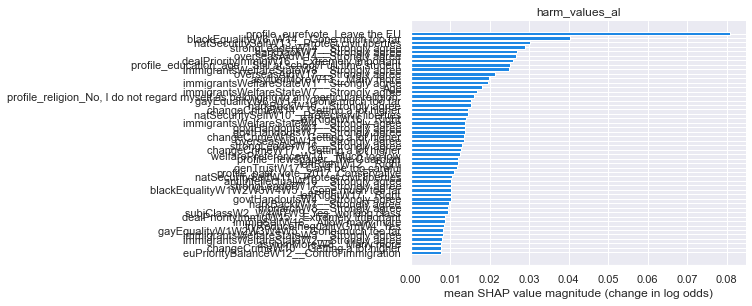

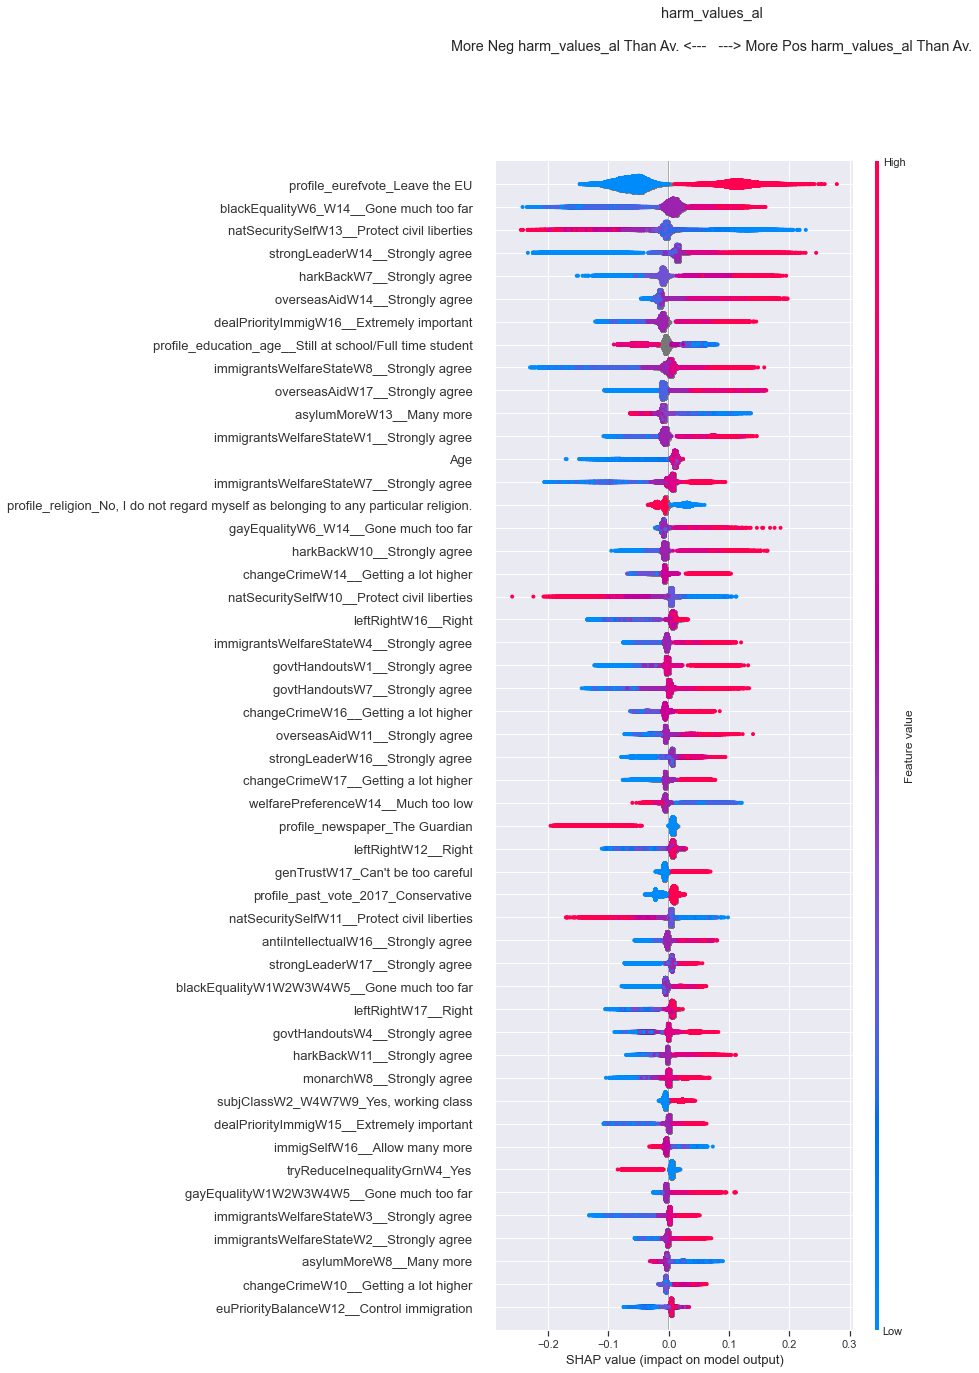

Wall time: 2h 14min 8s


In [62]:
%%time

Treatment = "predicted_al_values"
var1 = "harm_values_al"
al_pan_data_col = pan_dataset_allr_values.columns[3]
BES_reduced_with_na[var1]= pan_dataset_allr_values[ al_pan_data_col ]

base = "harm_values_al"

mask = BES_reduced_with_na[var1].notnull()

al_predictors = [x for x in al_corrs.abs().dropna().sort_values(ascending=False).head(5000).index if x not in base_value_vars]
al_predictors.append(var1)
df = BES_reduced_with_na[al_predictors][mask].astype('float32')

var_stub = var1

var_list = [var_stub]
var_stub_list = [var_stub]


(explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment] = shap_array(shap_values, train_columns, threshold = .1, min_features = 50)

In [63]:
al_train_columns = train_columns
al_alg = alg
mask = pan_dataset_allr_values[ al_pan_data_col ].isnull()
al_pred = al_alg.predict(BES_reduced_with_na[al_train_columns][mask].astype('float32'))

In [64]:
gc.collect()

26047

In [61]:
memory_use(locs = locals().items())

           BES_reduced_with_na:   2.2GiB
                            df:   1.7GiB
                     BES_Panel: 913.0MiB
              pan_dataset_ages:  16.7MiB
                            _5:   9.2MiB
       pan_dataset_allr_values:   6.7MiB
                            _8:   6.7MiB
             pan_dataset_votes:   6.6MiB
                      var_type:   6.3MiB
                      lr_corrs:   1.9MiB


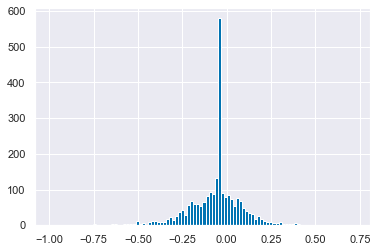

In [70]:
pd.Series(al_pred).hist(bins=100)

In [67]:
pan_dataset_allr_values.isnull().sum()

Economic: Left(0) <-> Right(200){uniform}                      2513
Social: Liberalism(0) <-> Conservatism(200){uniform}           2513
Economic: Left <-> Right{gaussian-ish}                         2513
Social: Liberalism <-> Conservatism{gaussian-ish}              2513
Economic: Left <-> Right{gaussian-ish}completish               2254
Economic: Left <-> Right{gaussian-ish}complete                  816
Social: Liberalism <-> Conservatism{gaussian-ish}completish    2174
Social: Liberalism <-> Conservatism{gaussian-ish}complete       736
dtype: int64

In [78]:
lr_complete_label = "Economic: Left <-> Right{gaussian-ish}complete"
lr_pred_Series = pd.Series(lr_pred,index=pan_dataset_allr_values[pan_dataset_allr_values[ lr_pan_data_col ].isnull()].index)
pan_dataset_allr_values[lr_complete_label+"_fully"] = pan_dataset_allr_values[lr_complete_label]
missing_value_indices = pan_dataset_allr_values[pan_dataset_allr_values[lr_complete_label].isnull()].index
pan_dataset_allr_values.loc[missing_value_indices,lr_complete_label+"_fully"] = lr_pred_Series.loc[missing_value_indices]


In [79]:
al_complete_label = "Social: Liberalism <-> Conservatism{gaussian-ish}complete"
al_pred_Series = pd.Series(al_pred,index=pan_dataset_allr_values[pan_dataset_allr_values[ al_pan_data_col ].isnull()].index)
pan_dataset_allr_values[al_complete_label+"_fully"] = pan_dataset_allr_values[al_complete_label]
missing_value_indices = pan_dataset_allr_values[pan_dataset_allr_values[al_complete_label].isnull()].index
pan_dataset_allr_values.loc[missing_value_indices,al_complete_label+"_fully"] = al_pred_Series.loc[missing_value_indices]


In [80]:
pan_dataset_allr_values.isnull().sum()

Economic: Left(0) <-> Right(200){uniform}                          2513
Social: Liberalism(0) <-> Conservatism(200){uniform}               2513
Economic: Left <-> Right{gaussian-ish}                             2513
Social: Liberalism <-> Conservatism{gaussian-ish}                  2513
Economic: Left <-> Right{gaussian-ish}completish                   2254
Economic: Left <-> Right{gaussian-ish}complete                      816
Social: Liberalism <-> Conservatism{gaussian-ish}completish        2174
Social: Liberalism <-> Conservatism{gaussian-ish}complete           736
Economic: Left <-> Right{gaussian-ish}complete_fully                  0
Social: Liberalism <-> Conservatism{gaussian-ish}complete_fully       0
dtype: int64

In [81]:
pan_dataset_allr_values.to_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
pan_dataset_allr_values.to_csv(BES_small_data_files + "pan_dataset_allr_valuesW19"+".csv")
lr_pred_Series.to_pickle(BES_small_data_files + "lr_pred_Series"+".zip",compression='zip')
al_pred_Series.to_pickle(BES_small_data_files + "al_pred_Series"+".zip",compression='zip')